# Emcee Testing

## Simple Lorentzian No Background - Works Great

In [56]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import emcee

import emtk.curves.lorentzian as lor


nsig = 10000
nbg = 5000
nbins = 50

xrange = np.array([0.001, 0.1])

clength = 90.0 # correlation length in system
kappa = 1.0 / clength
true_kappa = kappa
curv = lor.LorentzianCurve()
pvalues = np.array([kappa])
xrange = np.array([0.001, 0.1])

curv.generate_test_samples(pvalues, xrange, nsig)

#sig_dist = sp.stats.halfcauchy
#signal = sig_dist.rvs(scale=kappa, loc=0.0, size=nsig)

bg = np.random.uniform(xrange[0], xrange[1], nbg)

events = curv.data
#events = np.concatenate((curv.data, bg))


[0.0001]
Generated 10000 samples using parameters [0.01111111]


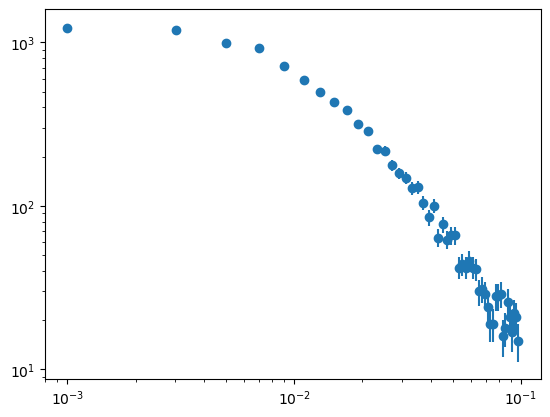

In [57]:
qmin = np.amin(events)
qmax = np.amax(events)
bins = np.linspace(qmin, qmax, nbins)
hst = np.histogram(events, bins=bins)
xvals = hst[1]
xvals = xvals[:-1]
yvals = hst[0]
evals = np.sqrt(yvals)

plt.errorbar(xvals, yvals, yerr=evals, ls='None', marker='o')
plt.yscale('log')
plt.xscale('log')

In [58]:
def log_prior(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    kappa = theta
    
    lolim = 0.001
    hilim = 0.1
    
    if lolim < kappa < hilim:
        return 0.0
    
    return -np.inf

def pmf(xvals, theta):
    
    kappa = np.asarray(theta)
    
    result = curv.curve(kappa, dat=xvals)    
    return result


def log_likelihood(theta):
    kappa = np.asarray(theta)
    
    
    lp = log_prior(theta)
    
    if np.isinf(lp):
        return -np.inf
    
    ll = curv.llcurve(kappa)
    
    result = lp + ll
    
    if np.isnan(result):
        print("NaN result for theta, prior", theta, lp)
    
    return result


p0 = np.array([0.02])


print(log_likelihood(p0))

21800.994005432134


In [59]:
ndim, nwalkers = 1, 32

p0 = np.array(0.02)

p0 = [p0 + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

# Set up the sampler.
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)

# Run a burn-in chain and save the final location.
state = sampler.run_mcmc(p0, 100)

# Run the production chain.
sampler.reset()
sampler.run_mcmc(state, 2000, progress=True);

100%|██████████████████████████████████████████| 2000/2000 [00:04<00:00, 491.88it/s]


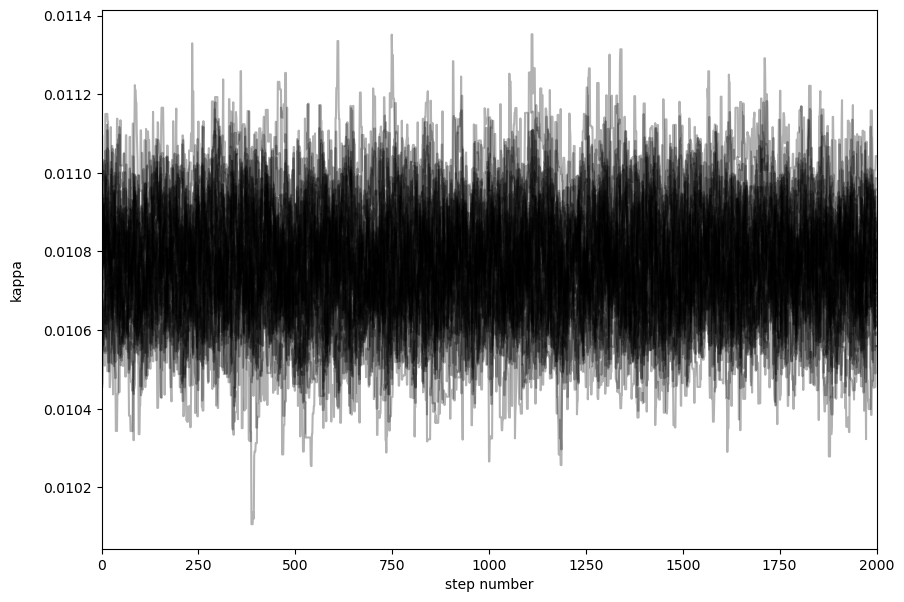

In [31]:
fig, ax = plt.subplots(1, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["kappa"]
ax.plot(samples[:, :, 0], "k", alpha=0.3)
ax.set_xlim(0, len(samples))
ax.set_ylabel(labels[0])
ax.yaxis.set_label_coords(-0.1, 0.5)

ax.set_xlabel("step number");

Acceptance fraction 0.809390625


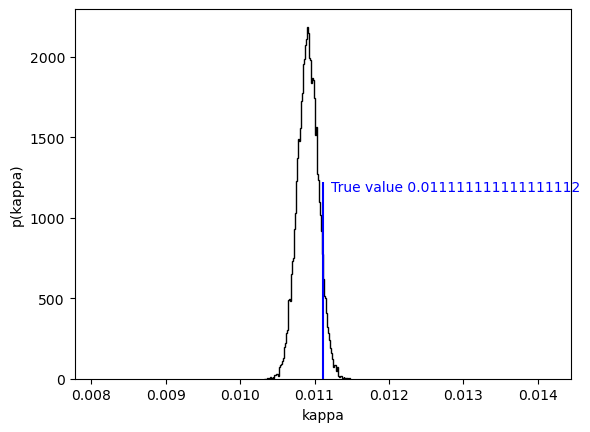

In [60]:
samples=sampler.get_chain(flat=True)

labeltxt = "True value " + str(true_kappa)

ytop = np.amax(hst[0])

hst=plt.hist(samples[:,0], 100, color='k', histtype="step")
plt.xlabel("kappa")
plt.ylabel("p(kappa)")
plt.vlines(true_kappa, 0, ytop, color='blue')
plt.xlim([true_kappa*0.7, true_kappa*1.3])
plt.text(true_kappa*1.01, ytop*0.95, labeltxt, color="blue")

print("Acceptance fraction", np.mean(sampler.acceptance_fraction))

Text(0.5, 0, 'Q (Å-1)')

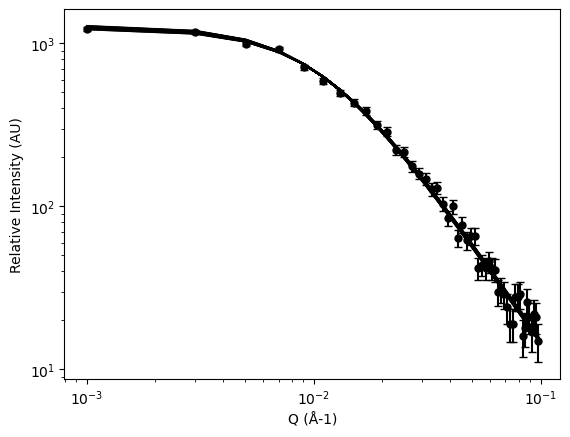

In [61]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

inds = np.random.randint(len(flat_samples), size=100)

pt_sum = np.sum(yvals)

fig, ax = plt.subplots()
for ind in inds:
    sample = flat_samples[ind]
    yplot = pmf(xvals, sample)
    ysum = np.sum(yplot)
    scale = pt_sum / ysum
    yplot = yplot * scale
    plt.plot(xvals, yplot, color='black', alpha = 0.4 )# np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)

plt.errorbar(xvals, yvals, yerr=np.sqrt(yvals), fmt=".k", markersize=10, capsize=3)
#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
#plt.legend(fontsize=14)
plt.ylabel("Relative Intensity (AU)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q (Å-1)')

## Lorentzian With Flat Background - DONE!

In [81]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import emcee

import emtk.curves.lorentzian as lor


nsig = 10000
nbg = 1000

ratio = float(nbg) / float(nsig)
nbins = 50

xrange = np.array([0.001, 0.1])

clength = 90.0 # correlation length in system
kappa = 1.0 / clength
true_kappa = kappa
curv = lor.LorentzianCurve()
pvalues = np.array([kappa])
xrange = np.array([0.001, 0.1])

curv.generate_test_samples(pvalues, xrange, nsig)

curv.generate_background(xrange, ratio = ratio)


events = curv.data

study_data = events

[0.0001]
Generated 10000 samples using parameters [0.01111111]
Adding flat background of 1000.0 points


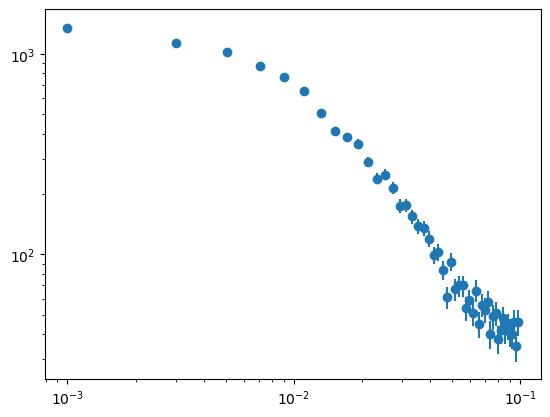

In [82]:
xmin = np.amin(events)
xmax = np.amax(events)
bins = np.linspace(xmin, xmax, nbins)
hst = np.histogram(events, bins=bins)
x_hist = hst[1]
x_hist = x_hist[:-1]
y_hist = hst[0]
e_hist = np.sqrt(y_hist)

plt.errorbar(x_hist, y_hist, yerr=e_hist, ls='None', marker='o')
plt.yscale('log')
plt.xscale('log')

In [83]:
def log_prior(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    kappa, logQ = theta
    
    lolim = 0.001
    hilim = 0.1
    
    if lolim < kappa < hilim and -4.0 < logQ < 1.0:# and 0.1 < sigma < 3.0:
        return 0.0
    
    return -np.inf

def bg_integral(xmin, xmax):
    # Returns the integral over the range of x values
    
    # Assume y=1 over the range
    return xmax-xmin

def cauchy_integral(xmin, xmax, kappa):
    # Returns the integral over the range of x values
    t1 = np.arctan(xmax/kappa)
    t2 = np.arctan(xmin/kappa)
    
    return (t1 - t2)/np.pi

def get_weights(xvals, theta):
    # Figure out the color weight of the point based on its *signal* likelihood
    kappa, logQ = theta
    
    bg_int = bg_integral(xmin, xmax)    
    sig_int = cauchy_integral(xmin, xmax, kappa)
    
    #bg_y = 10.0**logQ
    bgQ = 10.0**logQ
    sigQ = 1.0-bgQ
    
    yvals = curv.curve(np.array([kappa]), dat=xvals)
    
    yweight = (yvals * sigQ) / bgQ
    
    #yweight = (yvals/sig_int) / (bg_y/bg_int + yvals/sig_int)
    
    # if yweight = (yvals/sig_int) / (bg_y/bg_int + yvals/sig_int)
    # then signal / weight = bg_y/bg_int + yvals/sig_int
    # which is why that looks like it fits, because it's exactly the
    # function used to generate the data
    # The background term is so small it doesn't matter (I tried taking it out)
    # This is the wrong weighting function even though it seems right
    
#   This is an extreme cut test to see if other functions are working properly
#    mask = xvals > 4.0E-02
#    yweight = np.ones_like(xvals)   
#    yweight[mask] = 0.0
    
    
    return yweight

def get_color(xvals, theta):
    # Figure out the color of the point based on its signal likelihood
    kappa, logQ = theta
    
    bg_int = bg_integral(xmin, xmax)    
    sig_int = cauchy_integral(xmin, xmax, kappa)
    
    Q = 10.0**logQ
     
    yvals = curv.curve(np.array([kappa]), dat=xvals)
    
    yweight = (yvals/sig_int) / (1.0/bg_int + yvals/sig_int)
    
    color_r = np.full_like(yweight, 1.0)
    color_g = yweight
    color_b = 1.0-yweight
    
    color = np.stack((color_r, color_g, color_b), axis=1)
    
    print("yvals", yvals)
    print("Q", Q)
    print("yweight", yweight)
    
    return color
    

def pmf(xx, theta, verbose=False):
    gaus = sp.stats.norm
    
    kappa, logQ = theta
    
    
    bg_int = bg_integral(xmin, xmax)    
    sig_int = cauchy_integral(xmin, xmax, kappa)


    bgQ = 10.0**logQ
    sigQ = 1.0-bgQ
    
    signal = sigQ * curv.curve(np.array([kappa]), dat=xx) / sig_int
    background = bgQ / bg_int
        
    term1 = signal # / yweight
    term2 = background  # / (1.0 - yweight) #* (1.0 - yweight) # ) * gaus.pdf(x=xvals, loc=0.0, scale=sigma)
    
    if verbose:
        print("term 1:", term1)
        print("term 2:", term2)
    
    result = term1 + term2
    
    return result

def log_gaussian(sigma):
    xvals = curv.data
    gaus = sp.stats.norm
    
    gvals = gaus.pdf(x=xvals, loc=0.0, scale=sigma)
    
    log_gvals = np.log(gvals)
    
    slog_gvals = np.sum(log_gvals)
    
    return slog_gvals
    

def log_likelihood(theta, testing=False):
    kappa, logQ = theta
    
    if testing:
        verbose=True
        study_data = x_hist
    else:
        verbose=False
        study_data = events
    
    lp = log_prior(theta)
    
    if np.isinf(lp):
        return -np.inf
    
    
    bg_int = bg_integral(xmin, xmax)    
    sig_int = cauchy_integral(xmin, xmax, kappa)


    bgQ = 10.0**logQ
    sigQ = 1.0-bgQ
    
    signal = sigQ * curv.curve(np.array([kappa]), dat=study_data) / sig_int
    background = bgQ / bg_int
    

    #weights = (sig_Q/sig_int) / (bgQ/bg_int + sig_Q/sig_int)

    weights = get_weights(study_data, theta)
            
    inv_weights = 1.0/weights   
    
    bg_weights = 1.0 - weights
    
    inv_bg_weights = 1.0/bg_weights
    
    log_weights = np.log(weights)
    log_bg_weights = np.log(bg_weights) 
    ll = np.log(signal)
    lbg = np.log(background)
    
    weighted_ll = ll #+ log_weights
    weighted_lbg = lbg #+ log_bg_weights#*0.3 #* (1.0-weights)
    
    weighted_ll_sum = np.sum( np.logaddexp(weighted_ll, weighted_lbg))
    
    #ll = curv.llcurve(np.array([kappa]))
    #if np.isnan(ll):
    #    print("NaN result for theta, prior", theta, lp)

    # bg in this case is a wide gaussian, if it's wide enough it's flat
    # also, Q=0 is zero background (never happens because logQ is of course 
    # on a log scale
    ##lbg = logQ + log_gaussian(sigma)
    
    result = lp + weighted_ll_sum#, arg1, lbg
    
    if np.isnan(result):
        verbose=True
    
    if verbose:
        print("bg_int", bg_int)
        print("sig_int", sig_int)
    
        print("xvals", study_data)
        print("xrange", xmin, xmax)
    
        print("signal", signal)
        print("bgQ", background)
        
        print("weights", weights)
        print("bg_weights", 1.0-weights)
        
        print("inv weights", inv_weights)
        print("inv bg weights", inv_bg_weights)
        
        print("sig / wt", signal/weights)
        print("bg / bgwt", background/(1.0-weights))
        
        print("weighted ll", weighted_ll)
        print("weighted lbg", weighted_lbg)
    
    return result


p0 = np.array([0.01, -0.5])

print(cauchy_integral(xmin, xmax, 0.01))

p_correct_fit = np.array([0.01111, -0.001])

#pmf(xvals, p_wrong_fit, verbose=True)

print(log_likelihood(p_correct_fit, testing=True))


0.4365414923383469
bg_int 0.09897959887709501
sig_int 0.4361983843289776
xvals [0.00100003 0.00302003 0.00504002 0.00706001 0.00908    0.01109999
 0.01311998 0.01513998 0.01715997 0.01917996 0.02119995 0.02321994
 0.02523994 0.02725993 0.02927992 0.03129991 0.0333199  0.03533989
 0.03735989 0.03937988 0.04139987 0.04341986 0.04543985 0.04745985
 0.04947984 0.05149983 0.05351982 0.05553981 0.0575598  0.0595798
 0.06159979 0.06361978 0.06563977 0.06765976 0.06967976 0.07169975
 0.07371974 0.07573973 0.07775972 0.07977971 0.08179971 0.0838197
 0.08583969 0.08785968 0.08987967 0.09189967 0.09391966 0.09593965
 0.09795964]
xrange 0.0010000333942449834 0.09997963227133999
signal [0.14985225 0.14067195 0.12528358 0.10761132 0.09057011 0.07560125
 0.06308721 0.05287505 0.04461974 0.03795304 0.03254916 0.02814141
 0.0245191  0.02151837 0.01901251 0.01690342 0.01511488 0.01358733
 0.01227391 0.01113748 0.01014838 0.00928276 0.00852131 0.00784826
 0.00725067 0.00671783 0.00624085 0.00581229 0.005

In [84]:
ndim, nwalkers = 2, 32

p0 = np.array([0.02, -0.5])

p0 = [p0 + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

# Set up the sampler.
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)

# Run a burn-in chain and save the final location.
state = sampler.run_mcmc(p0, 100)

# Run the production chain.
sampler.reset()
sampler.run_mcmc(state, 500, progress=True);

/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_1715/2150101808.py:163: RuntimeWarning: invalid value encountered in log
  log_bg_weights = np.log(bg_weights)
100%|█████████████████████████████████████████████| 500/500 [00:11<00:00, 42.44it/s]


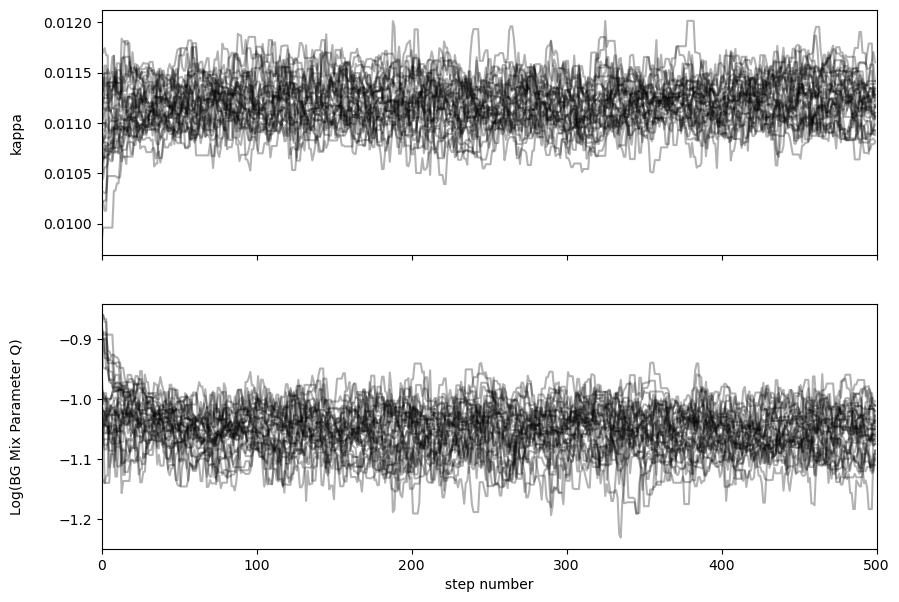

In [85]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["kappa", "Log(BG Mix Parameter Q)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Text(0.5, 0, 'Q (Å-1)')

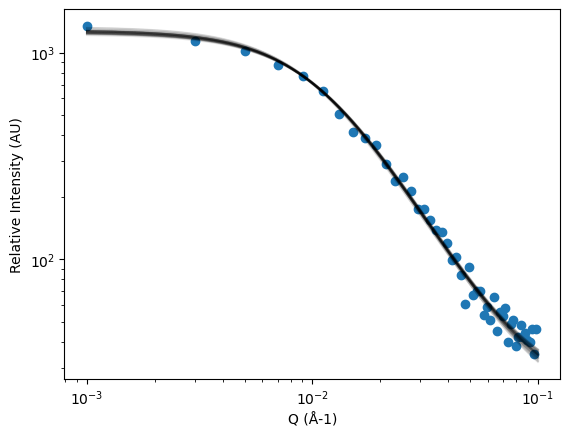

In [86]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

inds = np.random.randint(len(flat_samples), size=30)

pt_sum = np.sum(y_hist)

xfit_min = np.min(x_hist)
xfit_max = np.max(x_hist)
x_fit = np.linspace(xmin, xmax, 1000)

fig, ax = plt.subplots()
for ind in inds:
    sample = flat_samples[ind]
    y_fit = pmf(x_fit, sample)
    y_check = pmf(x_hist, sample)
    ysum = np.sum(y_check)
    scale = pt_sum / ysum
    y_fit = y_fit * scale
    plt.plot(x_fit, y_fit, color='black', alpha = 0.1)# np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)

#plt.errorbar(xvals, yvals, color=get_color(xvals, flat_samples[inds[0]]), yerr=np.sqrt(yvals), fmt=".k", markersize=10, capsize=3)
sct=plt.scatter(x_hist, y_hist)#, c=get_weights(xvals, flat_samples[inds[0]]), cmap='viridis')
#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
#plt.legend(fontsize=14)
plt.ylabel("Relative Intensity (AU)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q (Å-1)')
#cbar = fig.colorbar(sct)
#cbar.ax.set_ylabel('Point Signal Weight')


Acceptance fraction 0.7111875000000001 (should be high)
kappa estimate       : 0.011197455278693695  (true value = 0.011111111111111112 )
kappa std.dev.       : 0.000235044142005192


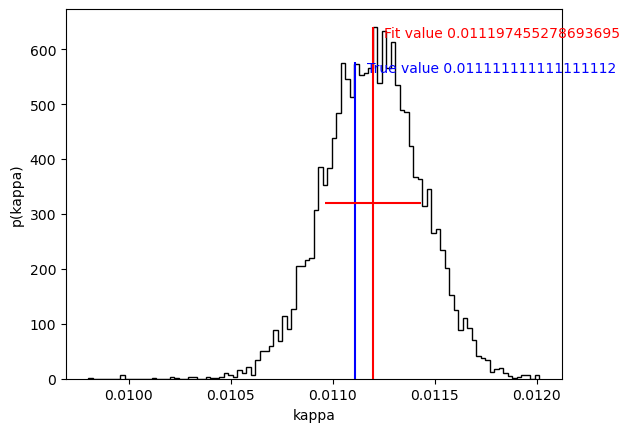

In [87]:
samples=sampler.get_chain(flat=True)

kappa_mean = np.mean(samples[:,0])
kappa_stddev = np.std(samples[:,0])

barmin = kappa_mean - kappa_stddev
barmax = kappa_mean + kappa_stddev

mix_mean = np.mean(samples[:,1])
mix_stddev= np.std(samples[:,1])

bg_fraction = 10.0**mix_mean


truetxt = "True value " + str(true_kappa)
fittxt = "Fit value " + str(kappa_mean)

hst=plt.hist(samples[:,0], 100, color='k', histtype="step")
ytop = np.amax(hst[0])
plt.xlabel("kappa")
plt.ylabel("p(kappa)")
plt.vlines(true_kappa, 0, ytop*0.9, color='blue')
plt.vlines(kappa_mean, 0, ytop, color="red")
plt.hlines(y=ytop*0.5, xmin=barmin, xmax=barmax, color="red")
#plt.xlim([true_kappa*0.7, true_kappa*1.3])
plt.text(true_kappa*1.005, ytop*0.87, truetxt, color="blue")
plt.text(kappa_mean*1.005, ytop*0.97, fittxt, color="red")

print("Acceptance fraction", np.mean(sampler.acceptance_fraction), "(should be high)")

print("kappa estimate       :", kappa_mean, " (true value =", true_kappa,")")
print("kappa std.dev.       :", kappa_stddev)

Background fraction    : 0.0890082913356692 (true value = 0.09090909090909091 )
Background frac std.dev: 0.008169519037176191
Acceptance fraction 0.7111875000000001 (should be high)


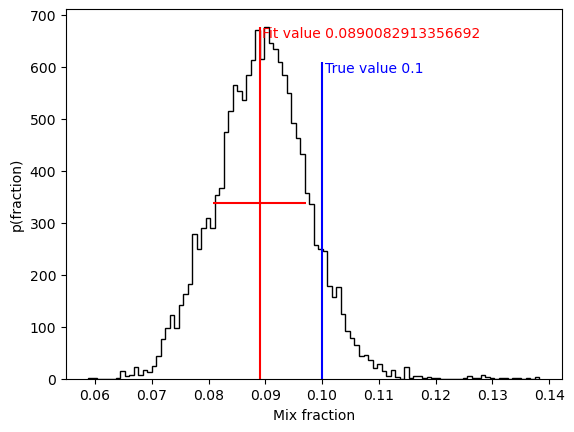

In [89]:
frac = 10.0**mix_mean
frac_stddev = frac * np.log(10.0)*mix_stddev

print("Background fraction    :", frac, "(true value =", nbg/(nbg+nsig), ")")
print("Background frac std.dev:", frac_stddev)

frac_samples = 10.0**samples[:,1]

barmin = frac - frac_stddev
barmax = frac + frac_stddev

truetxt = "True value 0.1"
fittxt = "Fit value " + str(frac)

hst=plt.hist(frac_samples, 100, color='k', histtype="step")
ytop = np.amax(hst[0])
plt.xlabel("Mix fraction")
plt.ylabel("p(fraction)")
plt.vlines(0.1, 0, ytop*0.9, color='blue')
plt.vlines(frac, 0, ytop, color="red")
plt.hlines(y=ytop*0.5, xmin=barmin, xmax=barmax, color="red")
#plt.xlim([true_kappa*0.7, true_kappa*1.3])
plt.text(0.1*1.005, ytop*0.87, truetxt, color="blue")
plt.text(frac*1.005, ytop*0.97, fittxt, color="red")

print("Acceptance fraction", np.mean(sampler.acceptance_fraction), "(should be high)")



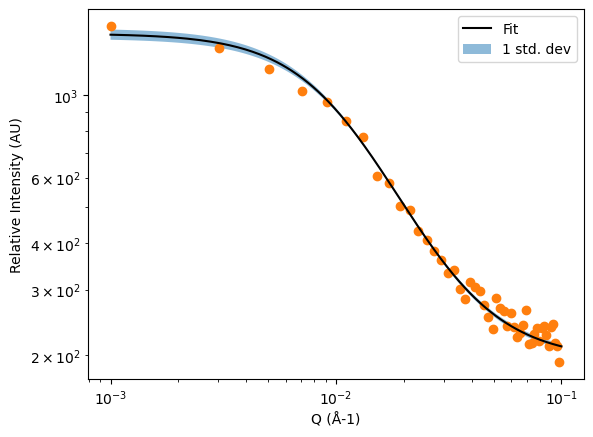

In [9]:

def perms(x_pts, means, devs):
    p1 = np.copy(means)
    p2 = np.copy(means)
    p3 = np.copy(means)
    
    p4 = np.copy(means)
    
    p5 = np.copy(means)
    p6 = np.copy(means)
    p7 = np.copy(means)
    
    p1 = p1 - devs
    p2[0] = p2[0] - devs[0]
    p3[1] = p3[1] - devs[1]
    
    p5[0] = p5[0] + devs[0]
    p6[1] = p6[1] + devs[1]
    p7 = p7 + devs
    
    y1 = pmf(x_pts, p1)
    y2 = pmf(x_pts, p2)
    y3 = pmf(x_pts, p3)
    y4 = pmf(x_pts, p4)
    y5 = pmf(x_pts, p5)
    y6 = pmf(x_pts, p6)
    y7 = pmf(x_pts, p7)
    
    arrays = np.array([y1, y2, y3, y4, y5, y6, y7])
    
    top = np.copy(y1)
    bot = np.copy(y1)
    
    
    for p in range(0, y1.size):
            top[p] = np.amax(arrays[:,p])
            bot[p] = np.amin(arrays[:,p])
    
    return top, bot
    
    

mean_pars = np.array([kappa_mean, mix_mean])
stddevs = np.array([kappa_stddev, mix_stddev])




flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

inds = np.random.randint(len(flat_samples), size=30)

pt_sum = np.sum(y_hist)

xfit_min = np.min(x_hist)
xfit_max = np.max(x_hist)
x_fit = np.linspace(xmin, xmax, 1000)

band_top, band_bottom = perms(x_fit, mean_pars, stddevs)


fig, ax = plt.subplots()


y_fit = pmf(x_fit, mean_pars)
y_check = pmf(x_hist, mean_pars)
ysum = np.sum(y_check)
scale = pt_sum / ysum
y_fit = y_fit * scale

band_bottom = band_bottom * scale
band_top = band_top * scale

plt.plot(x_fit, y_fit, color='black', label = "Fit")
plt.fill_between(x_fit, band_bottom, band_top, alpha=0.5, label="1 std. dev")


#plt.errorbar(xvals, yvals, color=get_color(xvals, flat_samples[inds[0]]), yerr=np.sqrt(yvals), fmt=".k", markersize=10, capsize=3)
sct=plt.scatter(x_hist, y_hist)#, c=get_weights(xvals, flat_samples[inds[0]]), cmap='viridis')
#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
#plt.legend(fontsize=14)
plt.ylabel("Relative Intensity (AU)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q (Å-1)')
plt.legend()
#cbar = fig.colorbar(sct)
#cbar.ax.set_ylabel('Point Signal Weight')

## Same Again with Beta-Distribution Weighting Hyperparameter

In [37]:
def log_prior(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    kappa, alpha, beta = theta
    
    lolim = 0.001
    hilim = 0.1
    
    if lolim < kappa < hilim and 1.0 <= alpha <= 5.0 and 1.0 <= beta <= 5.0:# and 0.1 < sigma < 3.0:
        return 0.0
    
    return -np.inf

def bg_integral(xmin, xmax):
    # Returns the integral over the range of x values
    
    # Assume y=1 over the range
    return xmax-xmin

def cauchy_integral(xmin, xmax, kappa):
    # Returns the integral over the range of x values
    t1 = np.arctan(xmax/kappa)
    t2 = np.arctan(xmin/kappa)
    
    return (t1 - t2)/np.pi

def get_weights(xvals, theta):
    # Figure out the color weight of the point based on its *signal* likelihood
    kappa, alpha, beta = theta
    
    bg_int = bg_integral(xmin, xmax)    
    sig_int = cauchy_integral(xmin, xmax, kappa)
    
    # Mode of beta distribution
    Q = (alpha - 1.0) / (alpha + beta - 2.0)
    
    #bg_y = 10.0**logQ
    bgQ = Q
    sigQ = 1.0-bgQ
    
    yvals = curv.curve(np.array([kappa]), dat=xvals)
    
    yweight = (yvals * sigQ) / bgQ
    
    #yweight = (yvals/sig_int) / (bg_y/bg_int + yvals/sig_int)
    
    # if yweight = (yvals/sig_int) / (bg_y/bg_int + yvals/sig_int)
    # then signal / weight = bg_y/bg_int + yvals/sig_int
    # which is why that looks like it fits, because it's exactly the
    # function used to generate the data
    # The background term is so small it doesn't matter (I tried taking it out)
    # This is the wrong weighting function even though it seems right
    
#   This is an extreme cut test to see if other functions are working properly
#    mask = xvals > 4.0E-02
#    yweight = np.ones_like(xvals)   
#    yweight[mask] = 0.0
    
    
    return yweight

def get_color(xvals, theta):
    # Figure out the color of the point based on its signal likelihood
    kappa, logQ = theta
    
    bg_int = bg_integral(xmin, xmax)    
    sig_int = cauchy_integral(xmin, xmax, kappa)
    
    Q = 10.0**logQ
     
    yvals = curv.curve(np.array([kappa]), dat=xvals)
    
    yweight = (yvals/sig_int) / (1.0/bg_int + yvals/sig_int)
    
    color_r = np.full_like(yweight, 1.0)
    color_g = yweight
    color_b = 1.0-yweight
    
    color = np.stack((color_r, color_g, color_b), axis=1)
    
    print("yvals", yvals)
    print("Q", Q)
    print("yweight", yweight)
    
    return color
    

def pmf(xx, theta, verbose=False):
    gaus = sp.stats.norm
    
    kappa, alpha, beta = theta
    
    
    bg_int = bg_integral(xmin, xmax)    
    sig_int = cauchy_integral(xmin, xmax, kappa)


    # Mode of beta distribution
    Q = (alpha - 1.0) / (alpha + beta - 2.0)
    
    #bg_y = 10.0**logQ
    bgQ = Q
    sigQ = 1.0-bgQ
    
    
    signal = sigQ * curv.curve(np.array([kappa]), dat=xx) / sig_int
    background = bgQ / bg_int
        
    term1 = signal # / yweight
    term2 = background  # / (1.0 - yweight) #* (1.0 - yweight) # ) * gaus.pdf(x=xvals, loc=0.0, scale=sigma)
    
    if verbose:
        print("term 1:", term1)
        print("term 2:", term2)
    
    result = term1 + term2
    
    return result

def log_gaussian(sigma):
    xvals = curv.data
    gaus = sp.stats.norm
    
    gvals = gaus.pdf(x=xvals, loc=0.0, scale=sigma)
    
    log_gvals = np.log(gvals)
    
    slog_gvals = np.sum(log_gvals)
    
    return slog_gvals
    

def log_likelihood(theta, testing=False):
    kappa, alpha, beta = theta
    
    if testing:
        verbose=True
        study_data = x_hist
    else:
        verbose=False
        study_data = events
    
    lp = log_prior(theta)
    
    if np.isinf(lp):
        return -np.inf
    
    
    bg_int = bg_integral(xmin, xmax)    
    sig_int = cauchy_integral(xmin, xmax, kappa)

    # Mode of beta distribution
    Q = (alpha - 1.0) / (alpha + beta - 2.0)
    
    #bg_y = 10.0**logQ
    bgQ = Q
    sigQ = 1.0-bgQ
    
    signal = sigQ * curv.curve(np.array([kappa]), dat=study_data) / sig_int
    background = bgQ / bg_int
    

    #weights = (sig_Q/sig_int) / (bgQ/bg_int + sig_Q/sig_int)

    weights = get_weights(study_data, theta)
            
    inv_weights = 1.0/weights   
    
    bg_weights = 1.0 - weights
    
    inv_bg_weights = 1.0/bg_weights
    
    log_weights = np.log(weights)
    log_bg_weights = np.log(bg_weights) 
    ll = np.log(signal)
    lbg = np.log(background)
    
    weighted_ll = ll #+ log_weights
    weighted_lbg = lbg #+ log_bg_weights#*0.3 #* (1.0-weights)
    
    weighted_ll_sum = np.sum( np.logaddexp(weighted_ll, weighted_lbg))
    
    #ll = curv.llcurve(np.array([kappa]))
    #if np.isnan(ll):
    #    print("NaN result for theta, prior", theta, lp)

    # bg in this case is a wide gaussian, if it's wide enough it's flat
    # also, Q=0 is zero background (never happens because logQ is of course 
    # on a log scale
    ##lbg = logQ + log_gaussian(sigma)
    
    result = lp + weighted_ll_sum#, arg1, lbg
    
    if np.isnan(result):
        verbose=True
    
    if verbose:
        print("kappa", kappa)
        print("alpha", alpha)
        print("beta", beta)
        print("alpha-1", alpha-1.0)
        print("alpha + beta - 2", alpha + beta - 2.0)
        print("sigQ", sigQ)
        print("bgQ", bgQ)
        print("bg_int", bg_int)
        print("sig_int", sig_int)
    
        print("xvals", study_data)
        print("xrange", xmin, xmax)
    
        print("signal", signal)
        print("bgQ", background)
        
        print("weights", weights)
        print("bg_weights", 1.0-weights)
        
        print("inv weights", inv_weights)
        print("inv bg weights", inv_bg_weights)
        
        print("sig / wt", signal/weights)
        print("bg / bgwt", background/(1.0-weights))
        
        print("weighted ll", weighted_ll)
        print("weighted lbg", weighted_lbg)
    
    return result


p0 = np.array([0.01, 2.0, 2.0])

print(cauchy_integral(xmin, xmax, 0.01))

p_correct_fit = np.array([0.01111, 2.0 ,2.0])

#pmf(xvals, p_wrong_fit, verbose=True)

print(log_likelihood(p_correct_fit, testing=True))


0.4365459858741066
kappa 0.01111
alpha 2.0
beta 2.0
alpha-1 1.0
alpha + beta - 2 2.0
sigQ 0.5
bgQ 0.5
bg_int 0.09899415181725156
sig_int 0.4362033847372798
xvals [0.00100004 0.00302033 0.00504061 0.0070609  0.00908119 0.01110148
 0.01312177 0.01514206 0.01716235 0.01918264 0.02120292 0.02322321
 0.0252435  0.02726379 0.02928408 0.03130437 0.03332466 0.03534495
 0.03736524 0.03938552 0.04140581 0.0434261  0.04544639 0.04746668
 0.04948697 0.05150726 0.05352755 0.05554783 0.05756812 0.05958841
 0.0616087  0.06362899 0.06564928 0.06766957 0.06968986 0.07171014
 0.07373043 0.07575072 0.07777101 0.0797913  0.08181159 0.08383188
 0.08585217 0.08787246 0.08989274 0.09191303 0.09393332 0.09595361
 0.0979739 ]
xrange 0.001000036411281329 0.09999418822853288
signal [32.57710402 30.58093784 27.23490216 23.3924411  19.68740671 16.43312193
 13.71266084 11.49270958  9.69820756  8.24907109  7.07446312  6.11639598
  5.32906317  4.67684648  4.13219523  3.6737865   3.28505281  2.95304709
  2.66758279  2

/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_1715/1680127029.py:174: RuntimeWarning: invalid value encountered in log
  log_bg_weights = np.log(bg_weights)


In [38]:
ndim, nwalkers = 3, 32

#p0 = np.array([0.02, -0.5])

p0 = [p0 + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

# Set up the sampler.
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)

# Run a burn-in chain and save the final location.
state = sampler.run_mcmc(p0, 100)

# Run the production chain.
sampler.reset()
sampler.run_mcmc(state, 500, progress=True);

/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_1715/1680127029.py:174: RuntimeWarning: invalid value encountered in log
  log_bg_weights = np.log(bg_weights)
100%|█████████████████████████████████████████| 500/500 [00:21<00:00, 23.71it/s]


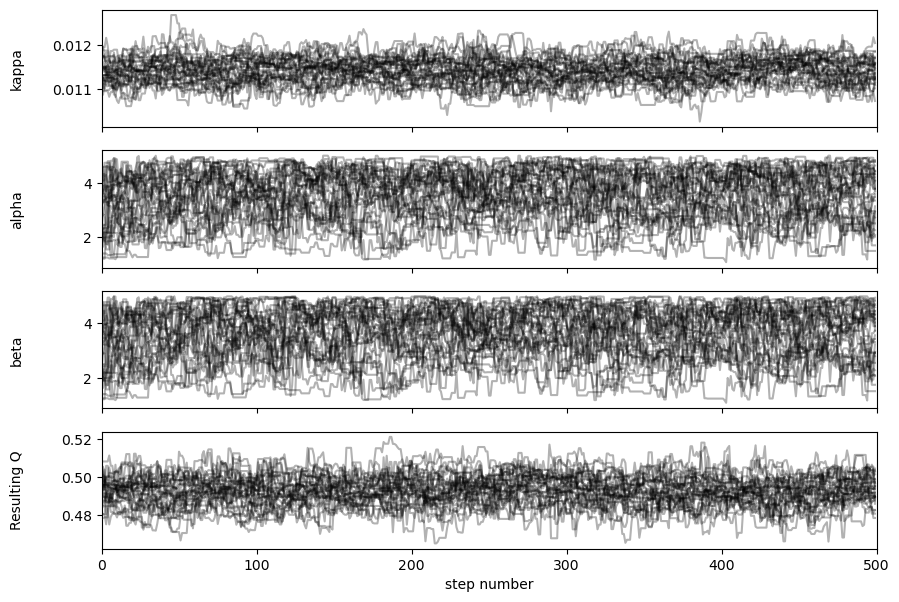

In [39]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["kappa", "alpha", "beta", "Resulting Q"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

ax = axes[3]

alphas=samples[:,:,1]
betas=samples[:,:,2]

qs = (alphas - 1.0) / (alphas + betas - 2.0)

ax.plot(qs, "k", alpha=0.3)
ax.set_ylabel(labels[3])
ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

Text(0.5, 0, 'Q (Å-1)')

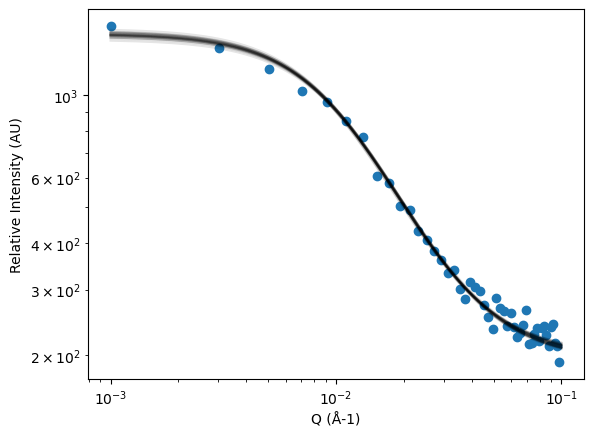

In [40]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

inds = np.random.randint(len(flat_samples), size=30)

pt_sum = np.sum(y_hist)

xfit_min = np.min(x_hist)
xfit_max = np.max(x_hist)
x_fit = np.linspace(xmin, xmax, 1000)

fig, ax = plt.subplots()
for ind in inds:
    sample = flat_samples[ind]
    y_fit = pmf(x_fit, sample)
    y_check = pmf(x_hist, sample)
    ysum = np.sum(y_check)
    scale = pt_sum / ysum
    y_fit = y_fit * scale
    plt.plot(x_fit, y_fit, color='black', alpha = 0.1)# np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)

#plt.errorbar(xvals, yvals, color=get_color(xvals, flat_samples[inds[0]]), yerr=np.sqrt(yvals), fmt=".k", markersize=10, capsize=3)
sct=plt.scatter(x_hist, y_hist)#, c=get_weights(xvals, flat_samples[inds[0]]), cmap='viridis')
#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
#plt.legend(fontsize=14)
plt.ylabel("Relative Intensity (AU)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q (Å-1)')
#cbar = fig.colorbar(sct)
#cbar.ax.set_ylabel('Point Signal Weight')

Acceptance fraction 0.6034999999999999 (should be high)
kappa estimate       : 0.011401957171257516  (true value = 0.011111111111111112 )
kappa std.dev.       : 0.0002696487531339724


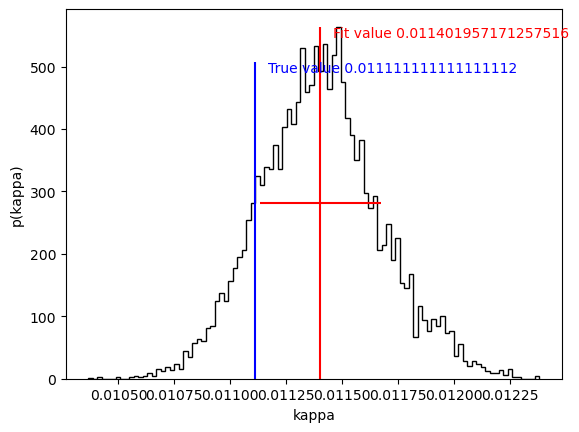

In [31]:
samples=sampler.get_chain(flat=True)

kappa_mean = np.mean(samples[:,0])
kappa_stddev = np.std(samples[:,0])

barmin = kappa_mean - kappa_stddev
barmax = kappa_mean + kappa_stddev

bg_fraction = 10.0**mix_mean


truetxt = "True value " + str(true_kappa)
fittxt = "Fit value " + str(kappa_mean)

hst=plt.hist(samples[:,0], 100, color='k', histtype="step")
ytop = np.amax(hst[0])
plt.xlabel("kappa")
plt.ylabel("p(kappa)")
plt.vlines(true_kappa, 0, ytop*0.9, color='blue')
plt.vlines(kappa_mean, 0, ytop, color="red")
plt.hlines(y=ytop*0.5, xmin=barmin, xmax=barmax, color="red")
#plt.xlim([true_kappa*0.7, true_kappa*1.3])
plt.text(true_kappa*1.005, ytop*0.87, truetxt, color="blue")
plt.text(kappa_mean*1.005, ytop*0.97, fittxt, color="red")

print("Acceptance fraction", np.mean(sampler.acceptance_fraction), "(should be high)")

print("kappa estimate       :", kappa_mean, " (true value =", true_kappa,")")
print("kappa std.dev.       :", kappa_stddev)

Background level    : 0.49292096884298703 (true value = 0.5 )
Background level std.dev: 0.007334964610395713
Acceptance fraction 0.6034999999999999 (should be high)


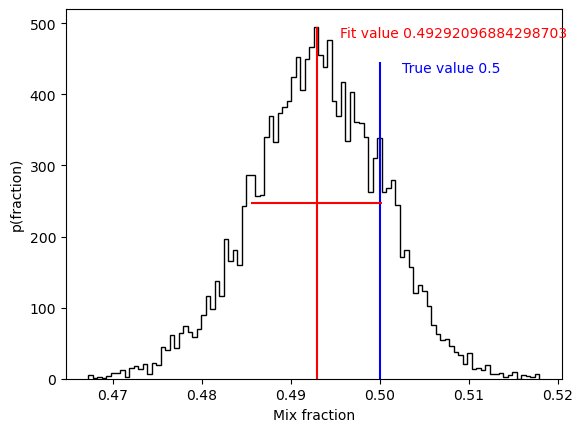

In [35]:
alphas = samples[:,1]
betas = samples[:,2]

qs = (alphas - 1.0) / (alphas + betas - 2.0)


q_mean = np.mean(qs)
q_std_dev = np.std(qs)

print("Background level    :", q_mean, "(true value =", nbg/(nbg+nsig), ")")
print("Background level std.dev:", q_std_dev)

barmin = q_mean - q_std_dev
barmax = q_mean + q_std_dev

truetxt = "True value 0.5"
fittxt = "Fit value " + str(q_mean)

hst=plt.hist(qs, 100, color='k', histtype="step")
ytop = np.amax(hst[0])
plt.xlabel("Mix fraction")
plt.ylabel("p(fraction)")
plt.vlines(0.5, 0, ytop*0.9, color='blue')
plt.vlines(q_mean, 0, ytop, color="red")
plt.hlines(y=ytop*0.5, xmin=barmin, xmax=barmax, color="red")
#plt.xlim([true_kappa*0.7, true_kappa*1.3])
plt.text(0.5*1.005, ytop*0.87, truetxt, color="blue")
plt.text(frac*1.005, ytop*0.97, fittxt, color="red")

print("Acceptance fraction", np.mean(sampler.acceptance_fraction), "(should be high)")

## Same Again Using Dirichlet Distribution (General Case) 

In [90]:
def log_prior(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    kappa, a1, a2 = theta
    
    alpha = np.array([a1, a2])
    
    lolim = 0.001
    hilim = 0.1
    
    if lolim < kappa < hilim and\
    np.all(1.0 < alpha) and\
    np.all(alpha < 5.0):
        return 0.0
    
    return -np.inf

def bg_integral(xmin, xmax):
    # Returns the integral over the range of x values
    
    # Assume y=1 over the range
    return xmax-xmin

def cauchy_integral(xmin, xmax, kappa):
    # Returns the integral over the range of x values
    t1 = np.arctan(xmax/kappa)
    t2 = np.arctan(xmin/kappa)
    
    return (t1 - t2)/np.pi

def get_weights(xvals, theta):
    # Figure out the color weight of the point based on its *signal* likelihood
    kappa, a1, a2 = theta
    
    alpha = np.array([a1, a2])
    K = 2
    
    alpha0 = np.sum(alpha)
    x_mode = (alpha - 1.0) / (alpha0 - K)
    
    bg_int = bg_integral(xmin, xmax)    
    sig_int = cauchy_integral(xmin, xmax, kappa)
    
    
    #bg_y = 10.0**logQ
    bgQ = x_mode[0]
    sigQ = x_mode[1]
    
    yvals = curv.curve(np.array([kappa]), dat=xvals)
    
    yweight = (yvals * sigQ) / bgQ
    
    #yweight = (yvals/sig_int) / (bg_y/bg_int + yvals/sig_int)
    
    # if yweight = (yvals/sig_int) / (bg_y/bg_int + yvals/sig_int)
    # then signal / weight = bg_y/bg_int + yvals/sig_int
    # which is why that looks like it fits, because it's exactly the
    # function used to generate the data
    # The background term is so small it doesn't matter (I tried taking it out)
    # This is the wrong weighting function even though it seems right
    
#   This is an extreme cut test to see if other functions are working properly
#    mask = xvals > 4.0E-02
#    yweight = np.ones_like(xvals)   
#    yweight[mask] = 0.0
    
    
    return yweight

def get_color(xvals, theta):
    # Figure out the color of the point based on its signal likelihood
    kappa, logQ = theta
    
    bg_int = bg_integral(xmin, xmax)    
    sig_int = cauchy_integral(xmin, xmax, kappa)
    
    Q = 10.0**logQ
     
    yvals = curv.curve(np.array([kappa]), dat=xvals)
    
    yweight = (yvals/sig_int) / (1.0/bg_int + yvals/sig_int)
    
    color_r = np.full_like(yweight, 1.0)
    color_g = yweight
    color_b = 1.0-yweight
    
    color = np.stack((color_r, color_g, color_b), axis=1)
    
    print("yvals", yvals)
    print("Q", Q)
    print("yweight", yweight)
    
    return color
    

def pmf(xx, theta, verbose=False):
    gaus = sp.stats.norm
    
    kappa, a1, a2 = theta
    
    alpha = np.array([a1, a2])
    K = 2
    
    alpha0 = np.sum(alpha)
    x_mode = (alpha - 1.0) / (alpha0 - K)
    
    bg_int = bg_integral(xmin, xmax)    
    sig_int = cauchy_integral(xmin, xmax, kappa)

    
    #bg_y = 10.0**logQ
    bgQ = x_mode[0]
    sigQ = x_mode[1]
    
    
    signal = sigQ * curv.curve(np.array([kappa]), dat=xx) / sig_int
    background = bgQ / bg_int
        
    term1 = signal # / yweight
    term2 = background  # / (1.0 - yweight) #* (1.0 - yweight) # ) * gaus.pdf(x=xvals, loc=0.0, scale=sigma)
    
    if verbose:
        print("term 1:", term1)
        print("term 2:", term2)
    
    result = term1 + term2
    
    return result

def log_gaussian(sigma):
    xvals = curv.data
    gaus = sp.stats.norm
    
    gvals = gaus.pdf(x=xvals, loc=0.0, scale=sigma)
    
    log_gvals = np.log(gvals)
    
    slog_gvals = np.sum(log_gvals)
    
    return slog_gvals
    

def log_likelihood(theta, testing=False):
    kappa, a1, a2 = theta
    
    alpha = np.array([a1, a2])
    K = 2
    
    alpha0 = np.sum(alpha)
    x_mode = (alpha - 1.0) / (alpha0 - K)
    
    if testing:
        verbose=True
        study_data = x_hist
    else:
        verbose=False
        study_data = events
    
    lp = log_prior(theta)
    
    if np.isinf(lp):
        return -np.inf
    
    
    bg_int = bg_integral(xmin, xmax)    
    sig_int = cauchy_integral(xmin, xmax, kappa)

    
    #bg_y = 10.0**logQ
    bgQ = x_mode[0]
    sigQ = x_mode[1]
    
    signal = sigQ * curv.curve(np.array([kappa]), dat=study_data) / sig_int
    background = bgQ / bg_int
    

    #weights = (sig_Q/sig_int) / (bgQ/bg_int + sig_Q/sig_int)

    weights = get_weights(study_data, theta)
            
    inv_weights = 1.0/weights   
    
    bg_weights = 1.0 - weights
    
    inv_bg_weights = 1.0/bg_weights
    
    log_weights = np.log(weights)
    log_bg_weights = np.log(bg_weights) 
    ll = np.log(signal)
    lbg = np.log(background)
    
    weighted_ll = ll #+ log_weights
    weighted_lbg = lbg #+ log_bg_weights#*0.3 #* (1.0-weights)
    
    weighted_ll_sum = np.sum( np.logaddexp(weighted_ll, weighted_lbg))
    
    #ll = curv.llcurve(np.array([kappa]))
    #if np.isnan(ll):
    #    print("NaN result for theta, prior", theta, lp)

    # bg in this case is a wide gaussian, if it's wide enough it's flat
    # also, Q=0 is zero background (never happens because logQ is of course 
    # on a log scale
    ##lbg = logQ + log_gaussian(sigma)
    
    result = lp + weighted_ll_sum#, arg1, lbg
    
    if np.isnan(result):
        verbose=True
    
    if verbose:
        print("kappa", kappa)
        print("alpha", alpha)
        print("sigQ", sigQ)
        print("bgQ", bgQ)
        print("bg_int", bg_int)
        print("sig_int", sig_int)
    
        print("xvals", study_data)
        print("xrange", xmin, xmax)
    
        print("signal", signal)
        print("bgQ", background)
        
        print("weights", weights)
        print("bg_weights", 1.0-weights)
        
        print("inv weights", inv_weights)
        print("inv bg weights", inv_bg_weights)
        
        print("sig / wt", signal/weights)
        print("bg / bgwt", background/(1.0-weights))
        
        print("weighted ll", weighted_ll)
        print("weighted lbg", weighted_lbg)
    
    return result


p0 = np.array([0.01, 2.0, 2.0])

print(cauchy_integral(xmin, xmax, 0.01))

p_correct_fit = np.array([0.01111, 2.0 ,2.0])

#pmf(xvals, p_wrong_fit, verbose=True)

print(log_likelihood(p_correct_fit, testing=True))


0.4365414923383469
kappa 0.01111
alpha [2. 2.]
sigQ 0.5
bgQ 0.5
bg_int 0.09897959887709501
sig_int 0.4361983843289776
xvals [0.00100003 0.00302003 0.00504002 0.00706001 0.00908    0.01109999
 0.01311998 0.01513998 0.01715997 0.01917996 0.02119995 0.02321994
 0.02523994 0.02725993 0.02927992 0.03129991 0.0333199  0.03533989
 0.03735989 0.03937988 0.04139987 0.04341986 0.04543985 0.04745985
 0.04947984 0.05149983 0.05351982 0.05553981 0.0575598  0.0595798
 0.06159979 0.06361978 0.06563977 0.06765976 0.06967976 0.07169975
 0.07371974 0.07573973 0.07775972 0.07977971 0.08179971 0.0838197
 0.08583969 0.08785968 0.08987967 0.09189967 0.09391966 0.09593965
 0.09795964]
xrange 0.0010000333942449834 0.09997963227133999
signal [32.57747905 30.5817065  27.23631566 23.39441358 19.68970084 16.43551144
 13.71499126 11.49489604  9.70021369  8.25088933  7.07610102  6.11786801
  5.33038614  4.67803718  4.13326933  3.6747581   3.28593433  2.95384937
  2.66831523  2.4212577   2.2062303   2.01804802  1.85

/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_1715/706524700.py:188: RuntimeWarning: invalid value encountered in log
  log_bg_weights = np.log(bg_weights)


In [91]:
ndim, nwalkers = 3, 32

#p0 = np.array([0.02, -0.5])

p0 = [p0 + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

# Set up the sampler.
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)

# Run a burn-in chain and save the final location.
state = sampler.run_mcmc(p0, 100)

# Run the production chain.
sampler.reset()
sampler.run_mcmc(state, 500, progress=True);

/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_1715/706524700.py:188: RuntimeWarning: invalid value encountered in log
  log_bg_weights = np.log(bg_weights)
100%|█████████████████████████████████████████████| 500/500 [00:10<00:00, 48.96it/s]


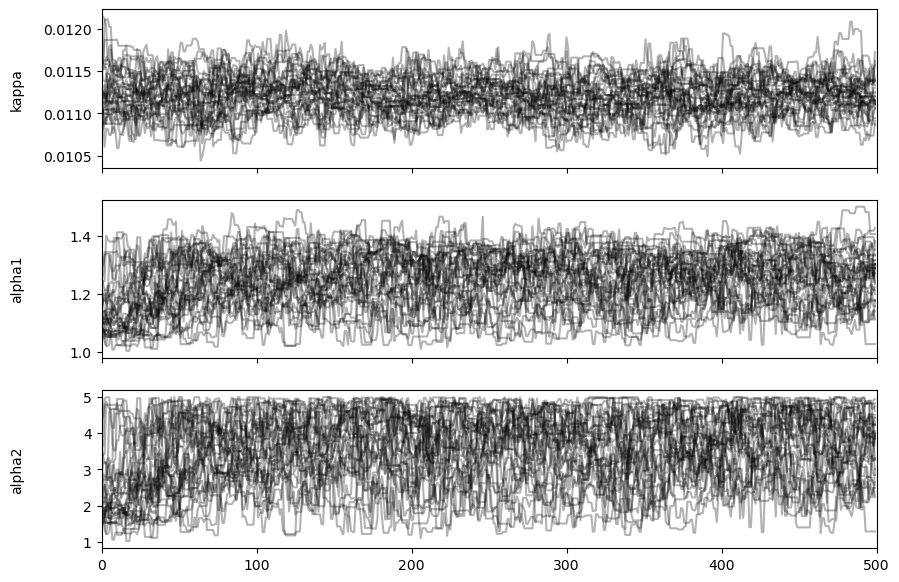

In [92]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["kappa", "alpha1", "alpha2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)


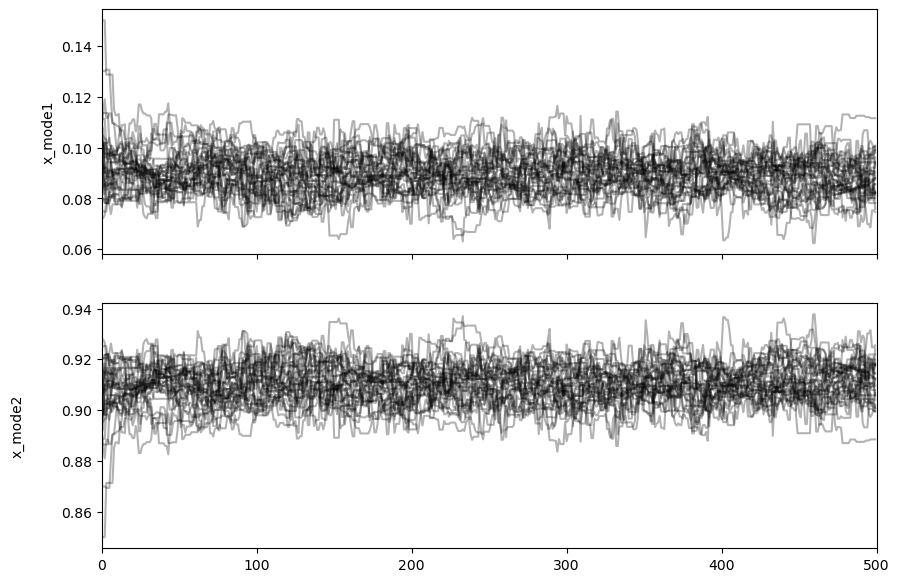

In [93]:
a1=samples[:, :, 1]
a2=samples[:, :, 2]

alpha0 = a1 + a2

x_mode0 = (a1 - 1.0)/(alpha0 - 2.0)
x_mode1 = (a2 - 1.0)/(alpha0 - 2.0)


fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["x_mode1", "x_mode2"]
ax = axes[0]
ax.plot(x_mode0, "k", alpha=0.3)
ax.set_xlim(0, len(x_mode0))
ax.set_ylabel(labels[0])

ax = axes[1]
ax.plot(x_mode1, "k", alpha=0.3)
ax.set_xlim(0, len(x_mode1))
ax.set_ylabel(labels[1])
ax.yaxis.set_label_coords(-0.1, 0.5)



Text(0.5, 0, 'Q (Å-1)')

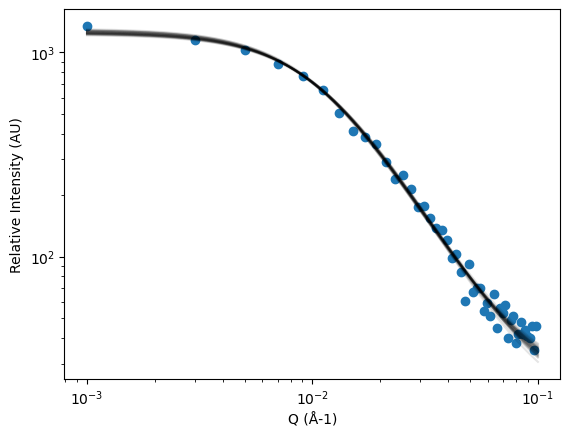

In [94]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

inds = np.random.randint(len(flat_samples), size=30)

pt_sum = np.sum(y_hist)

xfit_min = np.min(x_hist)
xfit_max = np.max(x_hist)
x_fit = np.linspace(xmin, xmax, 1000)

fig, ax = plt.subplots()
for ind in inds:
    sample = flat_samples[ind]
    y_fit = pmf(x_fit, sample)
    y_check = pmf(x_hist, sample)
    ysum = np.sum(y_check)
    scale = pt_sum / ysum
    y_fit = y_fit * scale
    plt.plot(x_fit, y_fit, color='black', alpha = 0.1)# np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)

#plt.errorbar(xvals, yvals, color=get_color(xvals, flat_samples[inds[0]]), yerr=np.sqrt(yvals), fmt=".k", markersize=10, capsize=3)
sct=plt.scatter(x_hist, y_hist)#, c=get_weights(xvals, flat_samples[inds[0]]), cmap='viridis')
#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
#plt.legend(fontsize=14)
plt.ylabel("Relative Intensity (AU)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q (Å-1)')
#cbar = fig.colorbar(sct)
#cbar.ax.set_ylabel('Point Signal Weight')

Acceptance fraction 0.5943125 (should be high)
kappa estimate       : 0.01121647613126825  (true value = 0.011111111111111112 )
kappa std.dev.       : 0.00022857911481776093


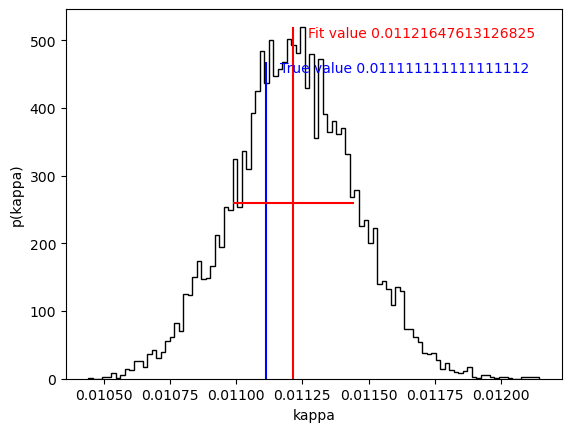

In [95]:
samples=sampler.get_chain(flat=True)

kappa_mean = np.mean(samples[:,0])
kappa_stddev = np.std(samples[:,0])

barmin = kappa_mean - kappa_stddev
barmax = kappa_mean + kappa_stddev

bg_fraction = 10.0**mix_mean


truetxt = "True value " + str(true_kappa)
fittxt = "Fit value " + str(kappa_mean)

hst=plt.hist(samples[:,0], 100, color='k', histtype="step")
ytop = np.amax(hst[0])
plt.xlabel("kappa")
plt.ylabel("p(kappa)")
plt.vlines(true_kappa, 0, ytop*0.9, color='blue')
plt.vlines(kappa_mean, 0, ytop, color="red")
plt.hlines(y=ytop*0.5, xmin=barmin, xmax=barmax, color="red")
#plt.xlim([true_kappa*0.7, true_kappa*1.3])
plt.text(true_kappa*1.005, ytop*0.87, truetxt, color="blue")
plt.text(kappa_mean*1.005, ytop*0.97, fittxt, color="red")

print("Acceptance fraction", np.mean(sampler.acceptance_fraction), "(should be high)")

print("kappa estimate       :", kappa_mean, " (true value =", true_kappa,")")
print("kappa std.dev.       :", kappa_stddev)

## Lorentzian With Systematic Background

In [245]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import emcee

import emtk.curves.lorentzian as lor
import emtk.curves.gaussian as gauss


nsig = 10000
nbg = 10000

ratio = float(nsig) / float(nbg)
nbins = 50

xrange = np.array([0.001, 0.1])

clength = 90.0 # correlation length in system
kappa = 1.0 / clength
curv = lor.LorentzianCurve()

pvalues = np.array([kappa])
xrange = np.array([0.001, 0.1])

curv.generate_test_samples(pvalues, xrange, nsig)


gau = gauss.GaussianCurve()
mu = 0.06
sigma = 0.005
gvalues = np.array([mu, sigma])

bg.generate_test_samples(gvalues, xrange, nbg)


events = np.concatenate((curv.data, bg.data))

np.random.shuffle(events)
curv.data = events

[0.0001]
Generated 10000 samples using parameters [0.01111111]
Generated 10000 samples using parameters [0.06  0.005]


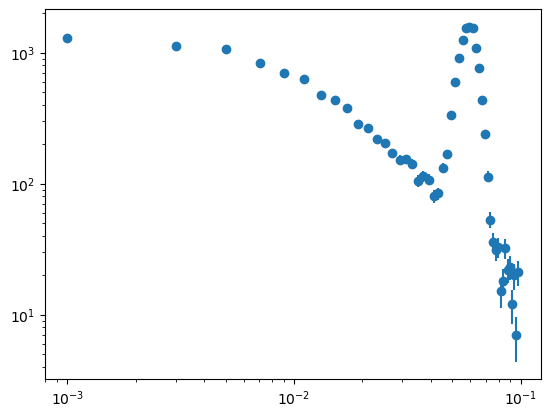

In [246]:
xmin = np.amin(events)
xmax = np.amax(events)
bins = np.linspace(xmin, xmax, nbins)
hst = np.histogram(events, bins=bins)
xvals = hst[1]
xvals = xvals[:-1]
yvals = hst[0]
evals = np.sqrt(yvals)

plt.errorbar(xvals, yvals, yerr=evals, ls='None', marker='o')
plt.yscale('log')
plt.xscale('log')

In [249]:
def log_prior(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    kappa, Q, mu, sigma = theta
    
    lolim = 0.001
    hilim = 0.1
    
    if lolim < kappa < hilim and 0.0 < Q < 1.0 and lolim < mu < hilim and lolim < sigma < 0.03:
        return 0.0
    
    return -np.inf

def gaussian_integral(xmin, xmax, mu, sigma):
    erf = sp.special.erf
    root2 = np.sqrt(2.0)
    t1 = (xmax-mu)/(root2 * sigma)
    t2 = (xmin-mu)/(root2 * sigma)
    
    result = 0.5 * (erf(t1)-erf(t2))
    
    return result
    

def bg_integral(xmin, xmax):
    # Returns the integral over the range of x values
    
    # Assume y=1 over the range
    return xmax-xmin

def cauchy_integral(xmin, xmax, kappa):
    # Returns the integral over the range of x values
    t1 = np.arctan(xmax/kappa)
    t2 = np.arctan(xmin/kappa)
    
    return (t1 - t2)/np.pi



def get_weights(xvals, theta):
    # Figure out the color weight of the point based on its signal likelihood
    kappa, Q, mu, sigma = theta
    
    bg_int = gaussian_integral(xmin, xmax, mu, sigma)    
    sig_int = cauchy_integral(xmin, xmax, kappa)
    
    bg_y = gau.curve(np.array([mu, sigma]), dat=xvals)
     
    yvals = curv.curve(np.array([kappa]), dat=xvals)
    
    yweight = (yvals/sig_int) / (bg_y/bg_int + yvals/sig_int)
    
#   This is an extreme cut test to see if other functions are working properly
#    mask = xvals > 4.0E-02
#    yweight = np.ones_like(xvals)   
#    yweight[mask] = 0.0
    
    
    return yweight



def get_color(xvals, theta):
    # Figure out the color of the point based on its signal likelihood
    kappa, Q, mu, sigma = theta
    
    bg_int = bg_integral(xmin, xmax)    
    sig_int = cauchy_integral(xmin, xmax, kappa)
    
    Q = 10.0**logQ
     
    yvals = curv.curve(np.array([kappa]), dat=xvals)
    
    yweight = (yvals/sig_int) / (1.0/bg_int + yvals/sig_int)
    
    color_r = np.full_like(yweight, 1.0)
    color_g = yweight
    color_b = 1.0-yweight
    
    color = np.stack((color_r, color_g, color_b), axis=1)
    
    print("yvals", yvals)
    print("Q", Q)
    print("yweight", yweight)
    
    return color
    

def pmf(xvals, theta, verbose=False):
    gaus = sp.stats.norm
    
    kappa, Q, mu, sigma = theta
    
    Q = 10.0**logQ
     
    yvals = curv.curve(np.array([kappa]), dat=xvals)
    
    bgvals= gau.curve(np.array([mu, sigma]), dat=xvals)
    
    yweight = get_weights(xvals, theta)
    
    term1 = yvals * yweight
    term2 = bgvals * (1.0 - yweight) #* (1.0 - yweight) # ) * gaus.pdf(x=xvals, loc=0.0, scale=sigma)
    
    if verbose:
        print("term 1:", term1)
        print("term 2:", term2)
    
    result = term1 + term2
    
    return result

                        
def log_gaussian(sigma):
    xvals = curv.data
    gaus = sp.stats.norm
    
    gvals = gaus.pdf(x=xvals, loc=0.0, scale=sigma)
    
    log_gvals = np.log(gvals)
    
    slog_gvals = np.sum(log_gvals)
    
    return slog_gvals
    

def log_likelihood(theta, testing=True):
    kappa, Q, mu, sigma = theta
    
    if testing:
        verbose=True
        study_data = xvals
    else:
        verbose=False
        study_data = events
    
    lp = log_prior(theta)
    
    if np.isinf(lp):
        return -np.inf
    
    
    bg_int = bg_integral(xmin, xmax)    
    sig_int = cauchy_integral(xmin, xmax, kappa)

    if verbose:
        print("bg_int", bg_int)
        print("sig_int", sig_int)
    
        print("xvals", xvals)
        print("xrange", xmin, xmax)
    
    sig_Q = curv.curve(np.array([kappa]), dat=study_data) #/ sig_int
    bgQ = gau.curve(np.array([mu, sigma]), dat=study_data)

    
    if verbose:
        print("sig_Q", sig_Q)
        print("bgQ", bgQ)
    weights = (sig_Q/sig_int) / (bgQ/bg_int + sig_Q/sig_int)

    weights = get_weights(study_data, theta)
    
    if verbose:
        print("weights", weights)
        print("bg_weights", 1.0-weights)
        
    
    bg_weights = 1.0 - weights
    
    #log_weights = np.log(weights)
    #log_bg_weights = np.log(bg_weights) 
    ll = np.log(sig_Q)
    lbg = np.log(bgQ)
    
    weighted_ll = ll * weights# + log_weights
    weighted_lbg = lbg * (1.0-weights)
    
    weighted_ll_sum = np.sum( np.logaddexp(weighted_ll, weighted_lbg))
    
    #ll = curv.llcurve(np.array([kappa]))
    #if np.isnan(ll):
    #    print("NaN result for theta, prior", theta, lp)

    # bg in this case is a wide gaussian, if it's wide enough it's flat
    # also, Q=0 is zero background (never happens because logQ is of course 
    # on a log scale
    ##lbg = logQ + log_gaussian(sigma)
    
    result = lp + weighted_ll_sum#, arg1, lbg
    
    if np.isnan(result):
        print("nan encountered at", theta)
    
    return result


p0 = np.array([0.01, 0.5, 0.01, 0.01])
#print(log_likelihood(p0))

p1 = np.array([0.01496048, 0.50451563, 0.02575426, 0.00161801])
print(log_likelihood(p1))
#p_wrong_fit = np.array([0.026, 0.5])

#pmf(xvals, p_wrong_fit, verbose=True)

bg_int 0.09865832014740804
sig_int 0.43131864448899276
xvals [0.00100031 0.00301375 0.00502718 0.00704062 0.00905405 0.01106749
 0.01308092 0.01509436 0.01710779 0.01912123 0.02113466 0.0231481
 0.02516153 0.02717497 0.0291884  0.03120184 0.03321527 0.03522871
 0.03724214 0.03925558 0.04126901 0.04328245 0.04529588 0.04730932
 0.04932275 0.05133619 0.05334962 0.05536306 0.05737649 0.05938993
 0.06140336 0.0634168  0.06543023 0.06744367 0.06945711 0.07147054
 0.07348398 0.07549741 0.07751085 0.07952428 0.08153772 0.08355115
 0.08556459 0.08757802 0.08959146 0.09160489 0.09361833 0.09563176
 0.0976452 ]
xrange 0.001000311558738507 0.09965863170614654
sig_Q [21.18201682 20.4469587  19.11797749 17.41883041 15.57291068 13.75107346
 12.05811421 10.54358422  9.22001477  8.079008    7.10237172  6.26876357
  5.55720013  4.94865863  4.42662426  3.97710486  3.58840715  3.25082987
  2.95635011  2.69833659  2.47130179  2.27069413  2.09272666  1.93423746
  1.79257632  1.66551305  1.55116326  1.44792

/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_3981/2973732451.py:174: RuntimeWarning: divide by zero encountered in log
  lbg = np.log(bgQ)
/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_3981/2973732451.py:177: RuntimeWarning: invalid value encountered in multiply
  weighted_lbg = lbg * (1.0-weights)


In [238]:
ndim, nwalkers = 4, 32

p0 = np.array([0.02, 0.5, 0.01, 0.01])

p0 = [p0 + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

# Set up the sampler.
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)

# Run a burn-in chain and save the final location.
state = sampler.run_mcmc(p0, 100)

# Run the production chain.
sampler.reset()
sampler.run_mcmc(state, 500, progress=True);

nan encountered at [0.01496048 0.50451563 0.02575426 0.00161801]


/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_3981/2212396294.py:174: RuntimeWarning: divide by zero encountered in log
  lbg = np.log(bgQ)
/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_3981/2212396294.py:177: RuntimeWarning: invalid value encountered in multiply
  weighted_lbg = lbg * (1.0-weights)


ValueError: Probability function returned NaN

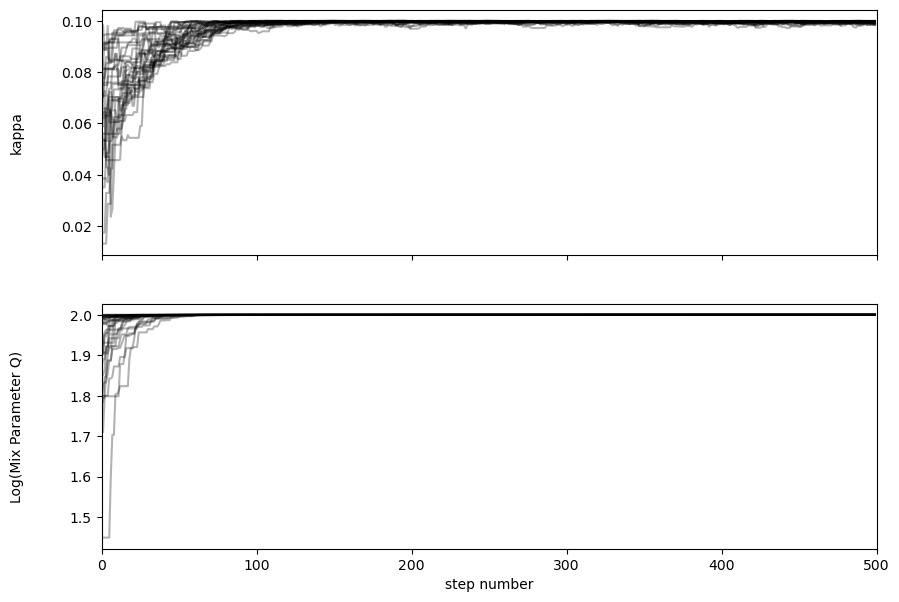

In [214]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["kappa", "Log(Mix Parameter Q)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Text(0, 0.5, 'Point Signal Weight')

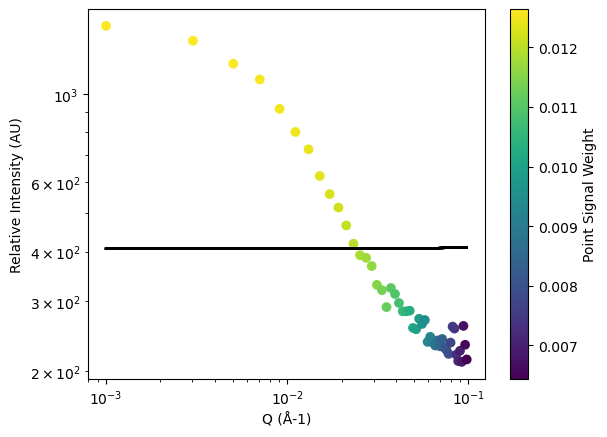

In [215]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

inds = np.random.randint(len(flat_samples), size=100)

pt_sum = np.sum(yvals)

fig, ax = plt.subplots()
for ind in inds:
    sample = flat_samples[ind]
    yplot = pmf(xvals, sample)
    ysum = np.sum(yplot)
    scale = pt_sum / ysum
    yplot = yplot * scale
    plt.plot(xvals, yplot, color='black', alpha = 0.4 )# np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)

#plt.errorbar(xvals, yvals, color=get_color(xvals, flat_samples[inds[0]]), yerr=np.sqrt(yvals), fmt=".k", markersize=10, capsize=3)
sct=plt.scatter(xvals, yvals, c=get_weights(xvals, flat_samples[inds[0]]), cmap='viridis')
#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
#plt.legend(fontsize=14)
plt.ylabel("Relative Intensity (AU)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q (Å-1)')
cbar = fig.colorbar(sct)
cbar.ax.set_ylabel('Point Signal Weight')


Acceptance fraction 0.34481249999999997 (should be high)


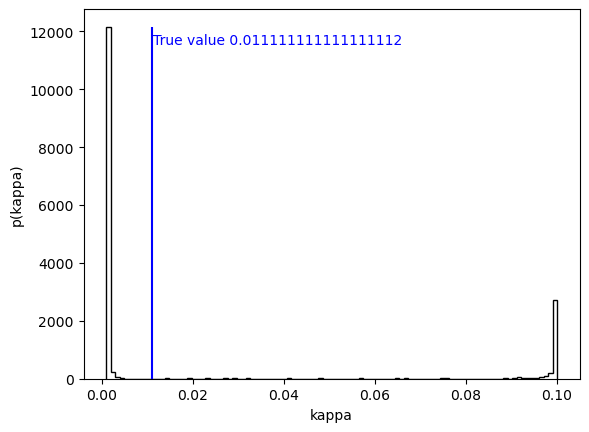

In [211]:
samples=sampler.get_chain(flat=True)

labeltxt = "True value " + str(true_kappa)

hst=plt.hist(samples[:,0], 100, color='k', histtype="step")
ytop = np.amax(hst[0])
plt.xlabel("kappa")
plt.ylabel("p(kappa)")
plt.vlines(true_kappa, 0, ytop, color='blue')
#plt.xlim([true_kappa*0.7, true_kappa*1.3])
plt.text(true_kappa*1.01, ytop*0.95, labeltxt, color="blue")

print("Acceptance fraction", np.mean(sampler.acceptance_fraction), "(should be high)")